In [1]:
%load_ext autoreload
%autoreload 2
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torchvision
from netcal.metrics import ECE
from laplace.utils import ModuleNameSubnetMask

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

import torch.nn as nn

import torch.nn.functional as F
import sys
import os
import seaborn as sns
from torchsummary import summary
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

sns.set(style='darkgrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [3]:
py_file_location = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/utils"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
py_file_location_src = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/data"
sys.path.append(os.path.abspath(py_file_location_src))

In [5]:
import make_dataset
import AffineTransform
from AffineTransform import make_affine_parameters
import compute_dim
from compute_dim import compute_conv_dim,compute_pool_dim
import SaveLoad
from SaveLoad import save_ckp
#from src.models.STN_seq import Net
from src.models.SpatialTN_2 import Net
from src.utils import visualization
from src.utils import laplace_checks

In [6]:
if torch.cuda.is_available():
      print("The code will run on GPU.")
else:
      print("The code will run on CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code will run on CPU.


In [7]:
config={
            "batch_size": 100,
            "num_classes": 10,
            "channels": 1,
            "filter1_out": 16,
            "kernel_size": 5,
            "pool": 2,
            "filter2_out": 32,
            "padding": 0,
            "stride": 1,
            "learning_rate_base": 0.001,
            "learning_rate_stn":0.0001,
            "epochs": 5,
            "crop_size": 128,
            "enc_sizes":[16,32],
            "loc_sizes":[8,10],
        }


In [8]:
train_loader,valid_loader,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],train_subset=10,misplacement=False,load=True,save=False,subset=False)

Getting MNIST
Train_data 42000
Validation_data 18000
Test_data 10000


In [9]:
model = Net(
        config["channels"],
        config["enc_sizes"],
        config["loc_sizes"],
        config["kernel_size"],
        config["padding"],
        config["num_classes"],
        parameterize=False).to(device).eval()

In [10]:
#model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_seq_misMNIST_10_HPC.pth'

#MNIST STN
model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/colab_best_MNIST_20_STN2__ver_2lr.pth'

#model_path ='/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_100_CPU.pth'

checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [11]:
acc_map,ece_map,nll_map,map_images,labels = laplace_checks.predict(test_loader,model,laplace=False)
print(
        f"[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}"
    )


[MAP] Acc.: 99.4%; ECE: 0.3%; NLL: 0.0202


# Experiment on Diagonal Laplace

In [12]:
diag_la,_ = laplace_checks.laplace(model,train_loader,method='last')
diag_la.optimize_prior_precision(method='marglik')

In [14]:
acc_diag,ece_diag,nll_diag,diag_la_images,_ = laplace_checks.predict(test_loader,diag_la,laplace=True)
print(
        f"[Diagonal Laplace] Acc.: {acc_diag:.1%}; ECE: {ece_diag:.1%}; NLL: {nll_diag:.3}"
    )

[Diagonal Laplace] Acc.: 99.3%; ECE: 17.9%; NLL: 0.225


In [15]:
diag_uncertain_images = laplace_checks.uncertainties(test_loader,diag_la_images,map_images)

In [15]:
test_images= []
for x,_ in test_loader:
    x = x.to(device)
    test_images.append(x)
    
test = torch.cat(test_images).cpu()

In [22]:
diag_preds= diag_la.predictive_samples(test,pred_type='glm',n_samples=100)

### Images with uncertainties Diagonal Laplace

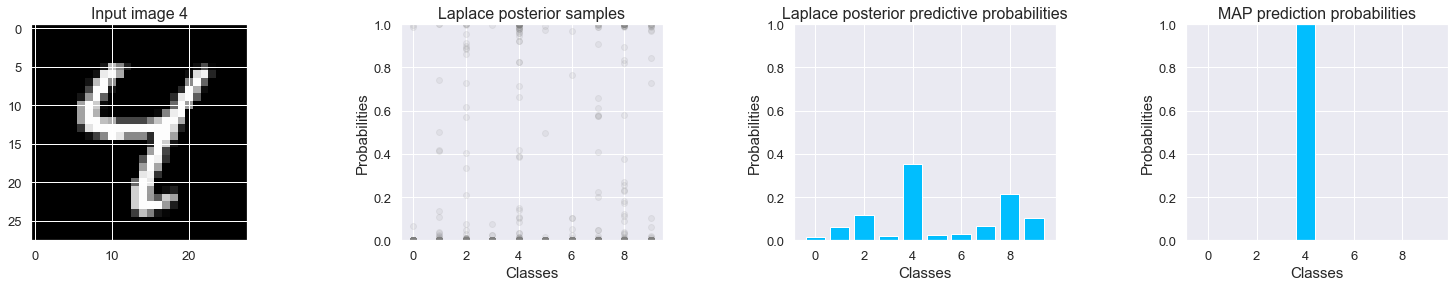

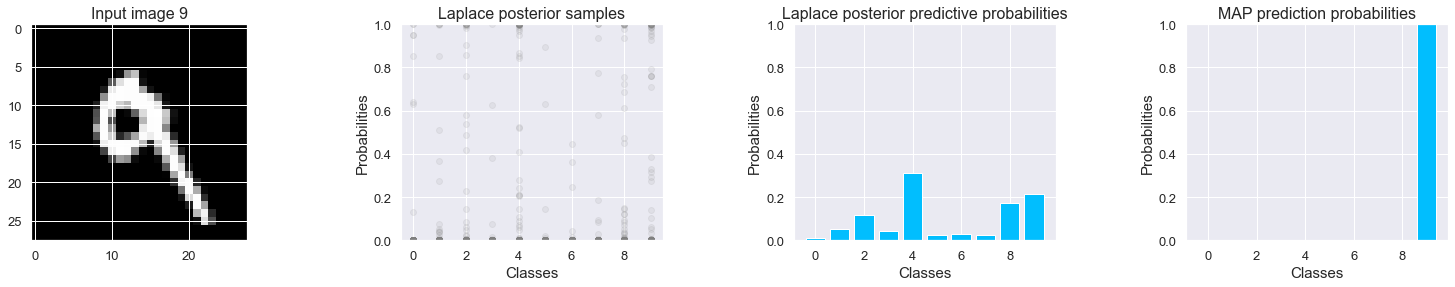

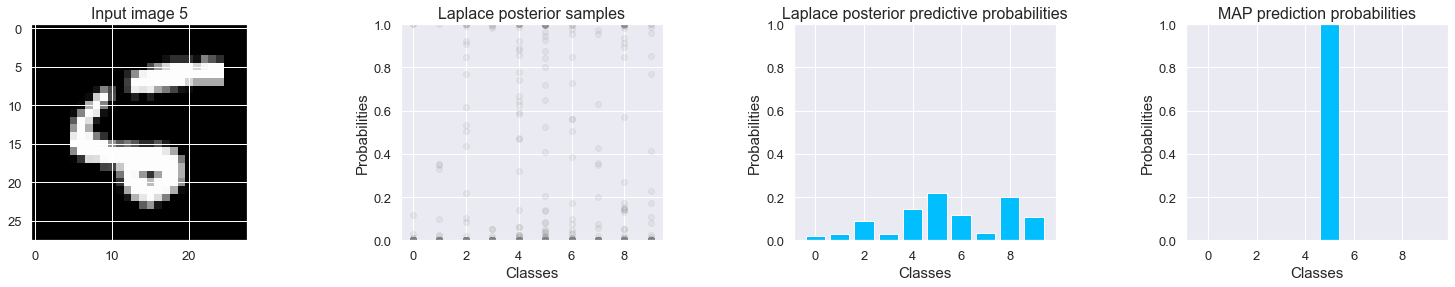

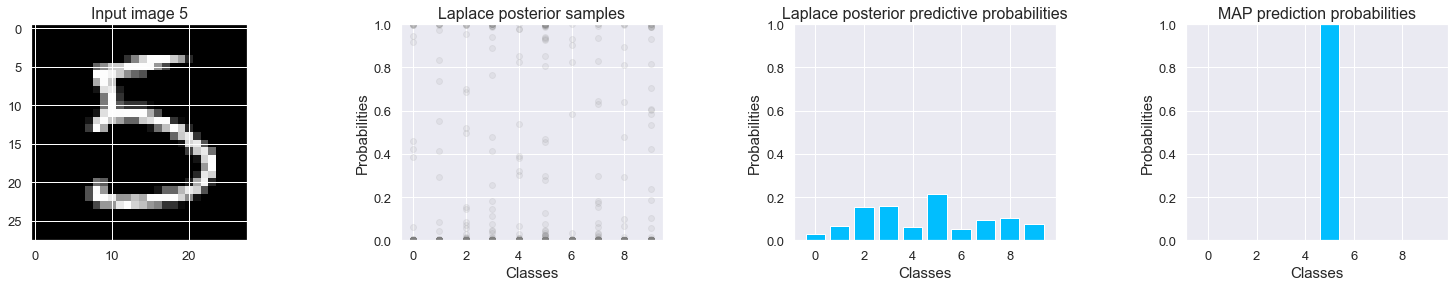

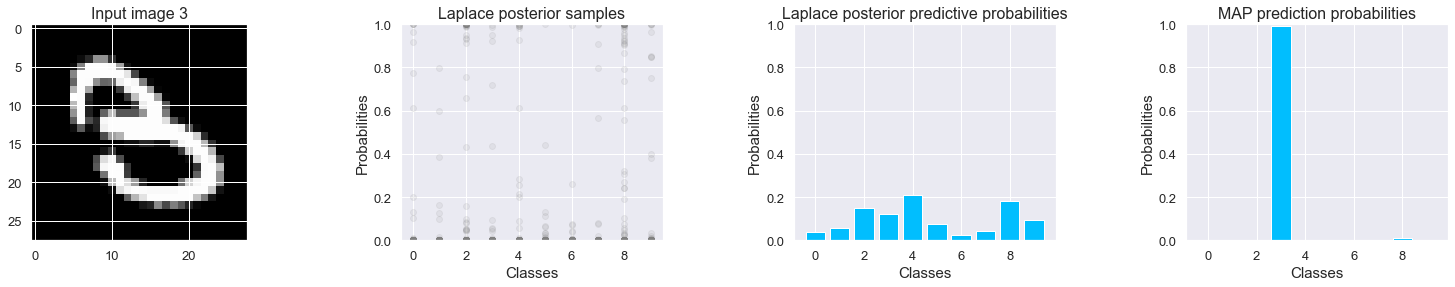

In [20]:
visualization.visualise_samples(diag_uncertain_images,test_loader,test,labels,diag_preds,diag_la_images,map_images)

### Misclassified images diagonal Laplace

In [20]:
diag_misclassified_images = []
for i in range(len(test_loader.dataset)):
    vla,pla = torch.max(diag_la_images[i],-1)
    v,p= torch.max(map_images[i],-1)
    if (p != labels[i]):
        diag_misclassified_images.append(i)


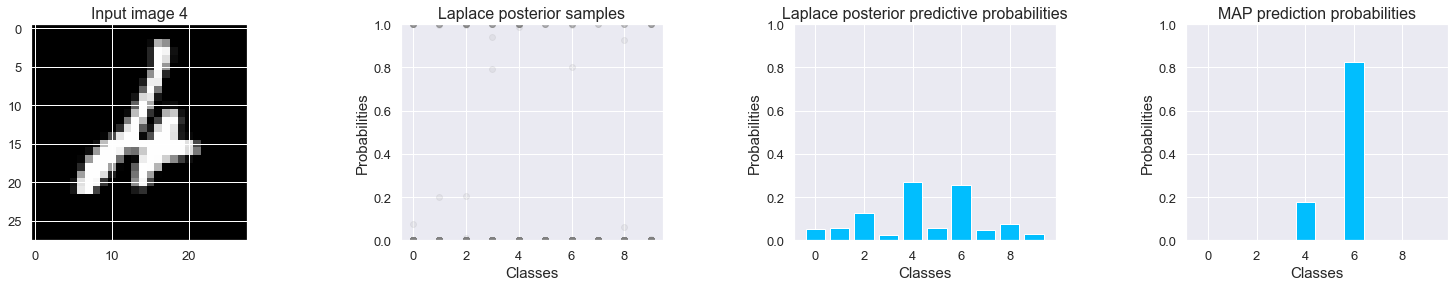

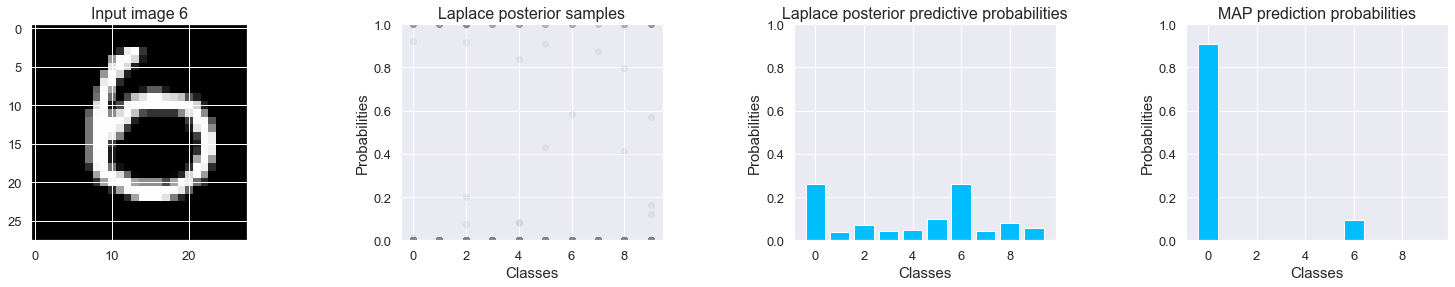

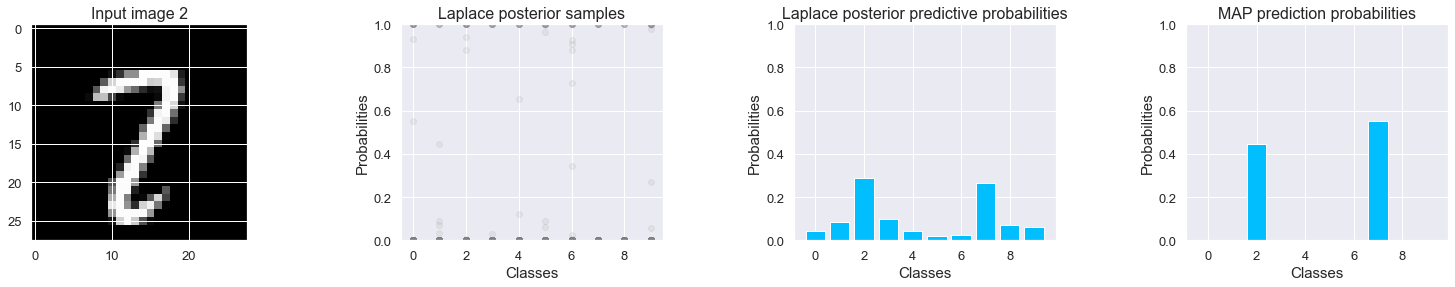

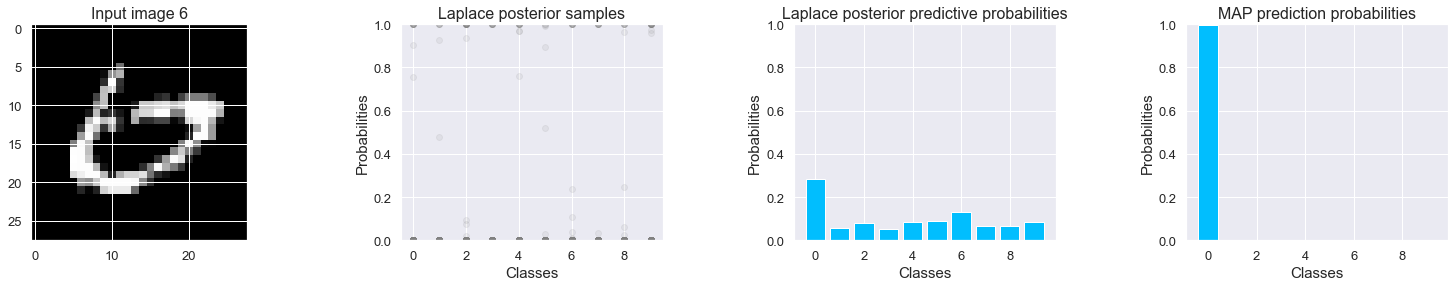

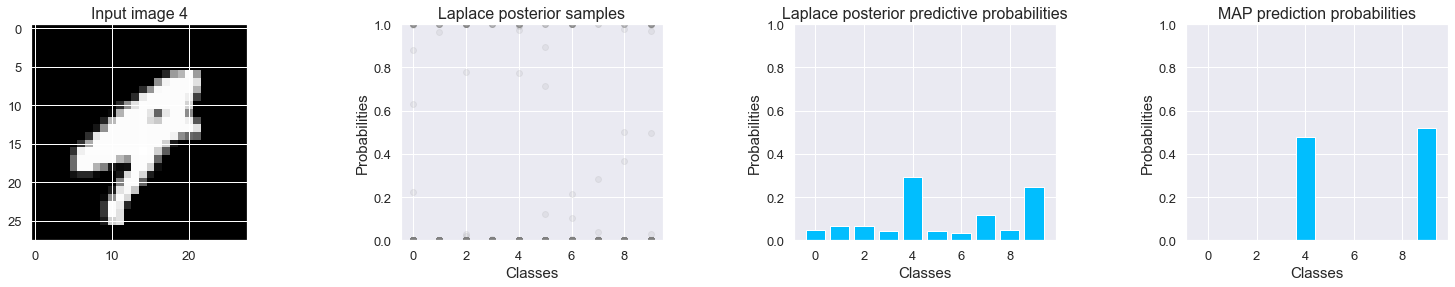

In [21]:
visualization.visualise_samples(diag_misclassified_images,test_loader,test,labels,diag_preds,diag_la_images,map_images)

# Last Layer Laplace

In [25]:
last_la,_ = laplace_checks.laplace(model,train_loader,method='last')
last_la.optimize_prior_precision(method='marglik')

In [26]:
acc_last,ece_last,nll_last,last_la_images,_ = laplace_checks.predict(test_loader,last_la,laplace=True)
print(
        f"[Diagonal Laplace] Acc.: {acc_last:.1%}; ECE: {ece_last:.1%}; NLL: {nll_last:.3}"
    )

[Diagonal Laplace] Acc.: 99.4%; ECE: 0.3%; NLL: 0.0198


In [27]:
last_uncertain_images = laplace_checks.uncertainties(test_loader,last_la_images,map_images)

In [28]:
last_preds= last_la.predictive_samples(test,pred_type='nn',n_samples=100)

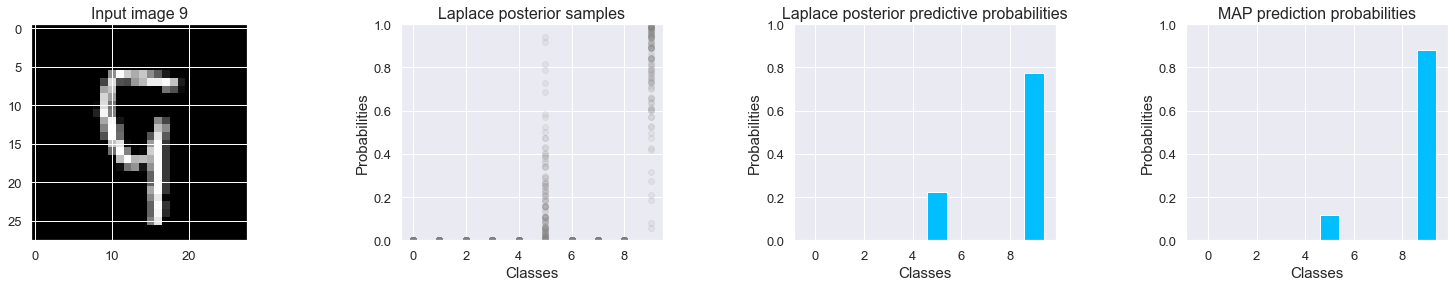

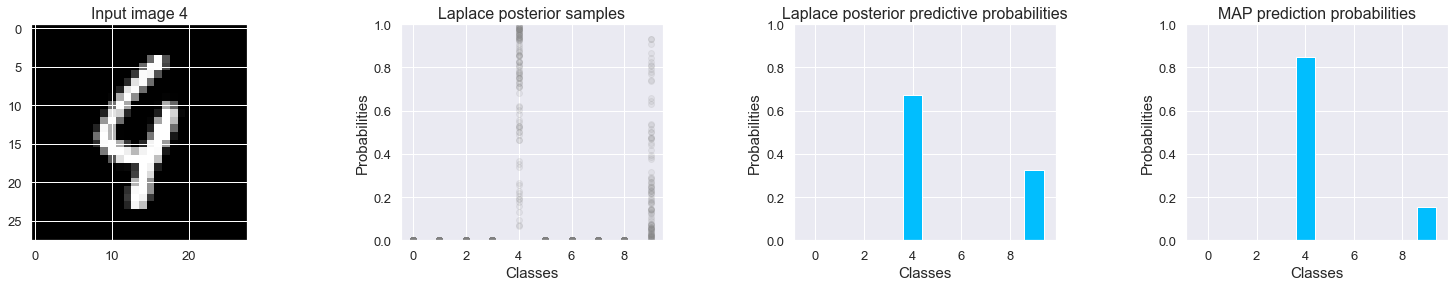

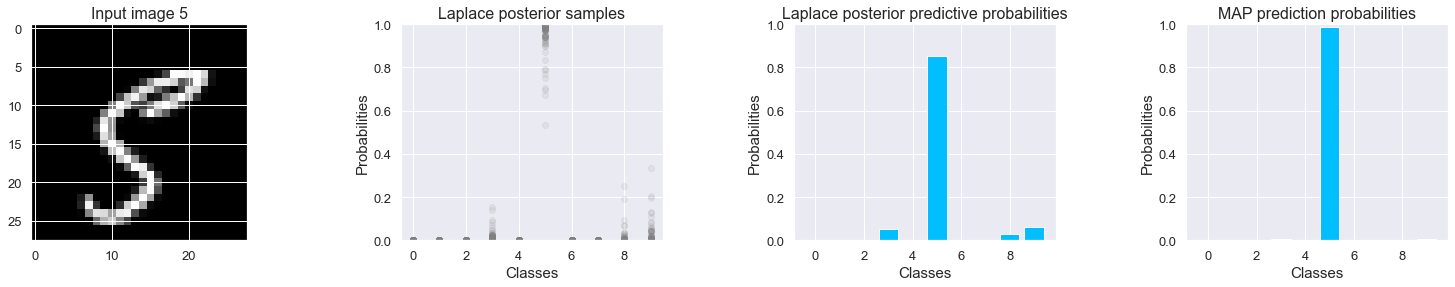

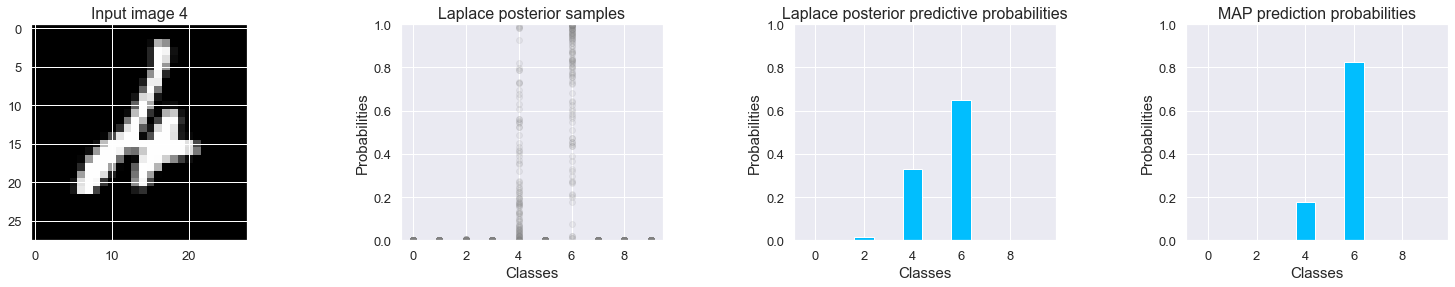

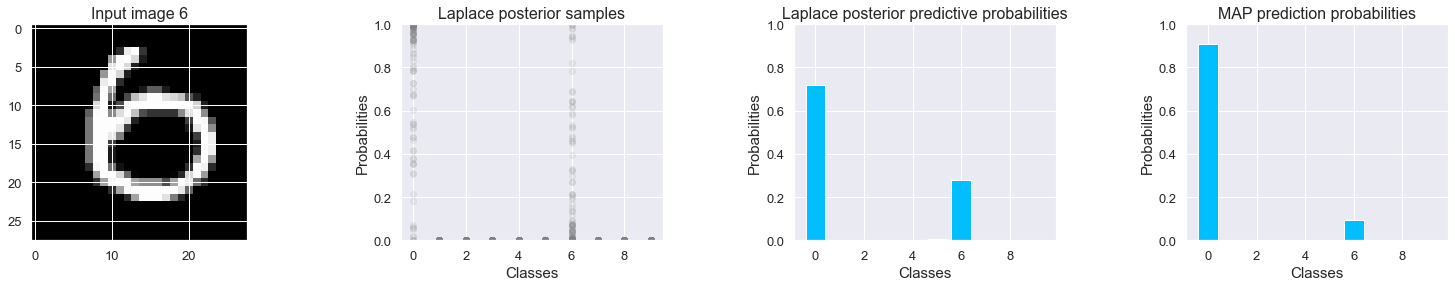

In [29]:
visualization.visualise_samples(last_uncertain_images,test_loader,test,labels,last_preds,last_la_images,map_images)

In [30]:
last_misclassified_images = []
for i in range(len(test_loader.dataset)):
    vla,pla = torch.max(last_la_images[i],-1)
    v,p= torch.max(map_images[i],-1)
    if (p != labels[i]):
        last_misclassified_images.append(i)


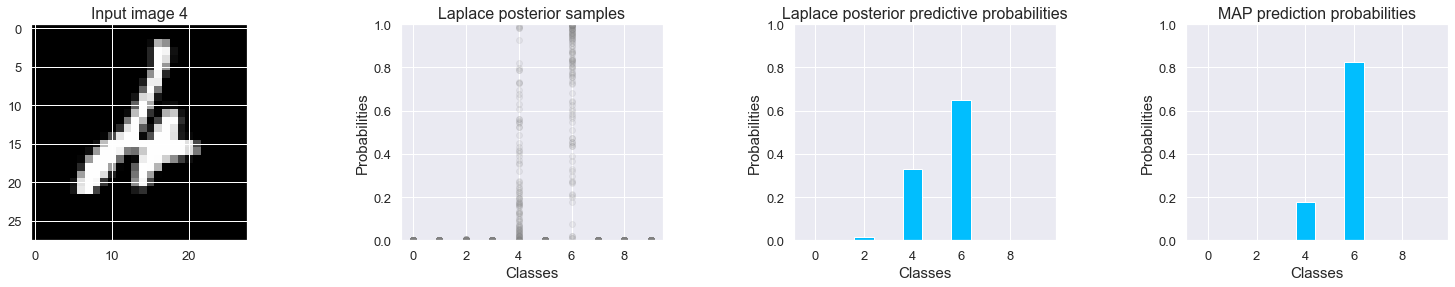

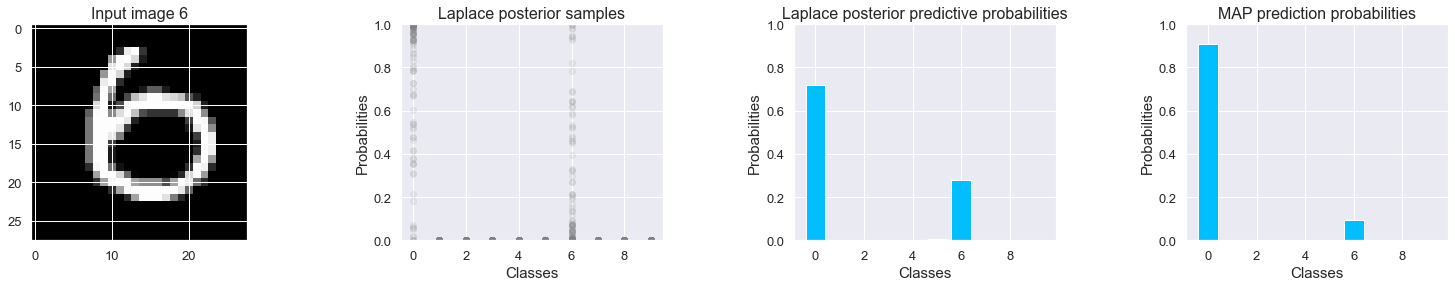

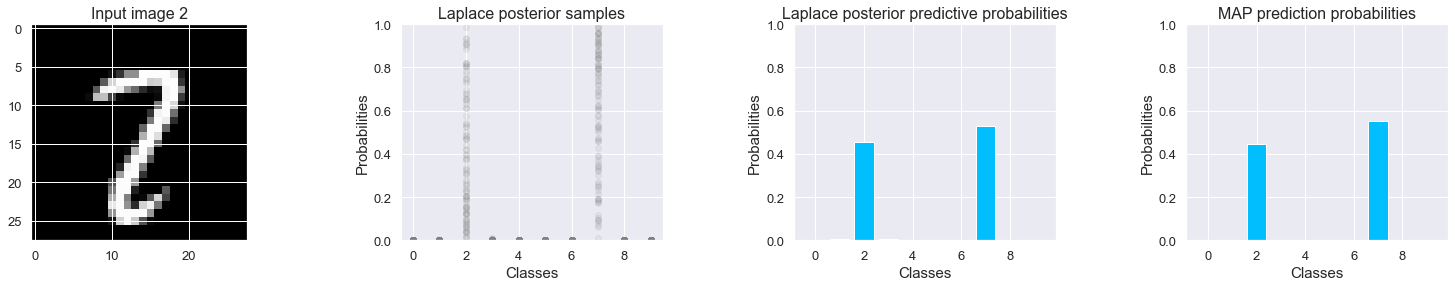

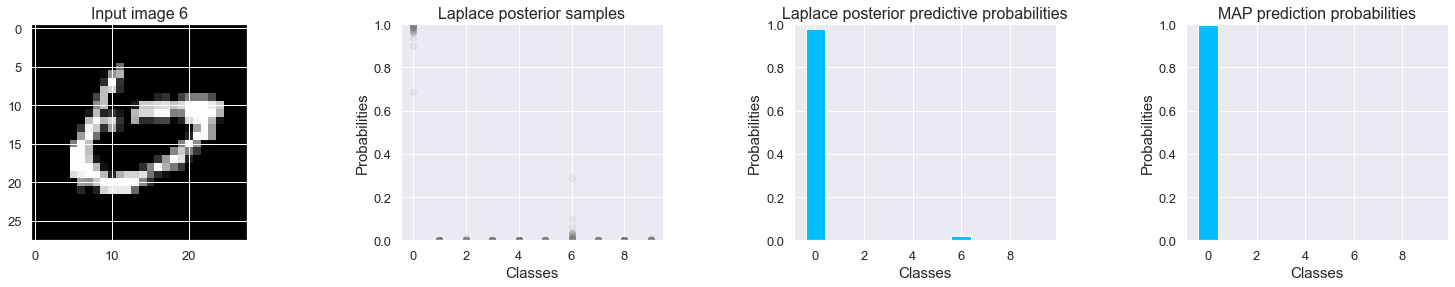

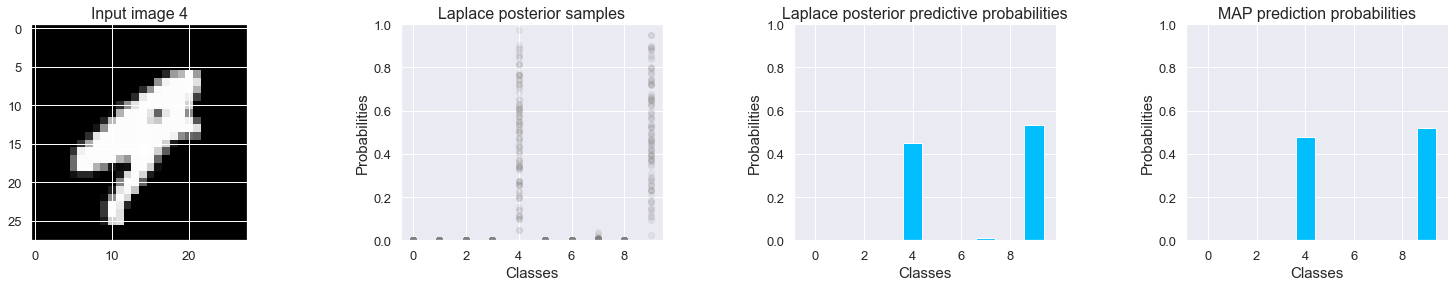

In [31]:
visualization.visualise_samples(last_misclassified_images,test_loader,test,labels,last_preds,last_la_images,map_images)

# OOD Distribution

In [32]:
batch_size = 128

                                    

set = torchvision.datasets.KMNIST(root='src/data', train=False,
                                       download=False, transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ))
loader = torch.utils.data.DataLoader(set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
test_ood_images= []
for x,_ in loader:
    x = x.to(device)
    test_ood_images.append(x)
    
test_ood = torch.cat(test_ood_images).cpu()

In [33]:
acc_map_ood,ece_map_ood,nll_map_ood,map_images_ood,labels_ood = laplace_checks.predict(loader,model,laplace=False)
print(
        f"[MAP] Acc.: {acc_map_ood:.1%}; ECE: {ece_map_ood:.1%}; NLL: {nll_map_ood:.3}"
    )


[MAP] Acc.: 8.9%; ECE: 70.9%; NLL: 8.2


### OOD Diagonal Laplace

In [ ]:
acc_diag_ood,ece_diag_ood,nll_diag_ood,diag_la_images_ood,_ = laplace_checks.predict(loader,diag_la,laplace=True)
print(
        f"[Sub Network Laplace] Acc.: {acc_diag_ood:.1%}; ECE: {ece_diag_ood:.1%}; NLL: {nll_diag_ood:.3}"
    )

In [ ]:
diag_ood_images = laplace_checks.uncertainties(loader,diag_la_images_ood,map_images_ood)

In [ ]:
diag_preds_ood= diag_la.predictive_samples(test_ood,pred_type='nn',n_samples=100)

In [ ]:
visualization.visualise_samples(diag_ood_images,loader,test_ood,labels_ood,diag_preds_ood,diag_la_images_ood,map_images_ood)

### OOD Last Layer Laplace

In [34]:
acc_last_ood,ece_last_ood,nll_last_ood,last_la_images_ood,_ = laplace_checks.predict(loader,last_la,laplace=True)
print(
        f"[Sub Network Laplace] Acc.: {acc_last_ood:.1%}; ECE: {ece_last_ood:.1%}; NLL: {nll_last_ood:.3}"
    )

[Sub Network Laplace] Acc.: 8.9%; ECE: 61.7%; NLL: 5.67


In [35]:
last_ood_images = laplace_checks.uncertainties(loader,last_la_images_ood,map_images_ood)

In [37]:
last_preds_ood= last_la.predictive_samples(test_ood,pred_type='nn',n_samples=100)

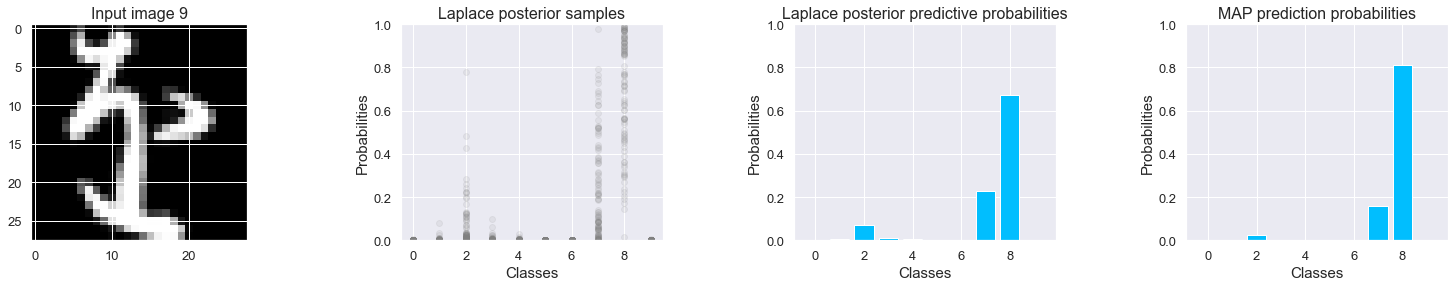

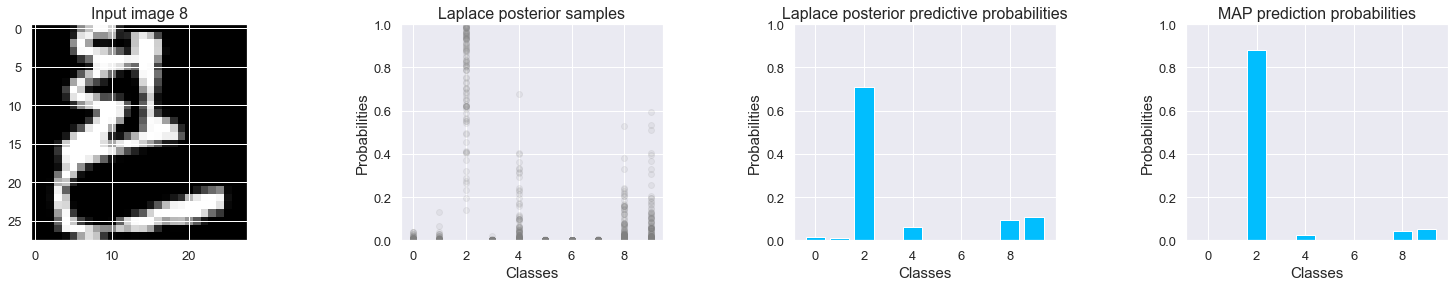

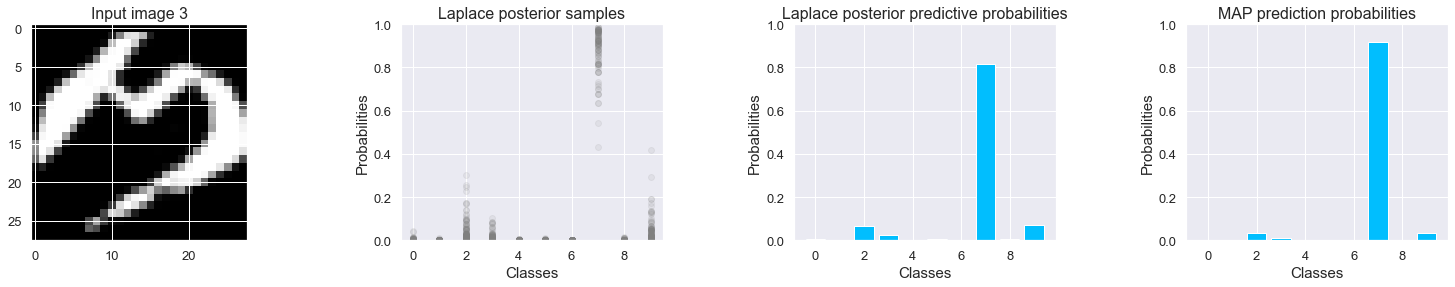

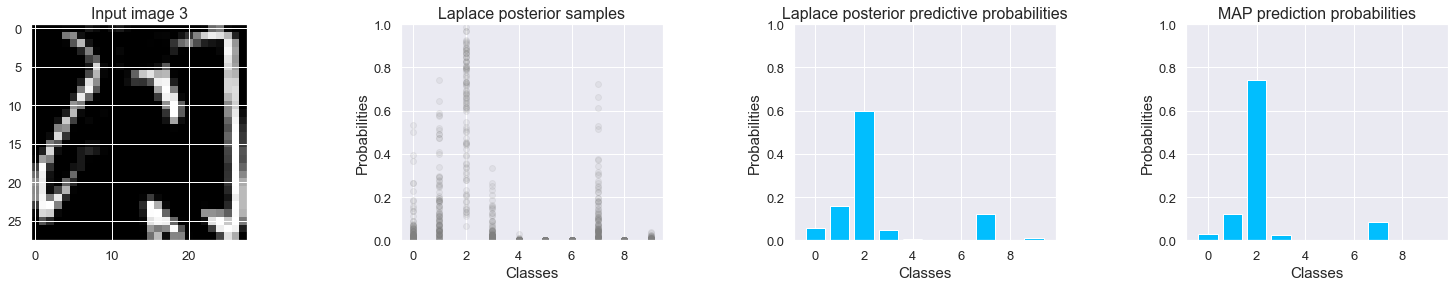

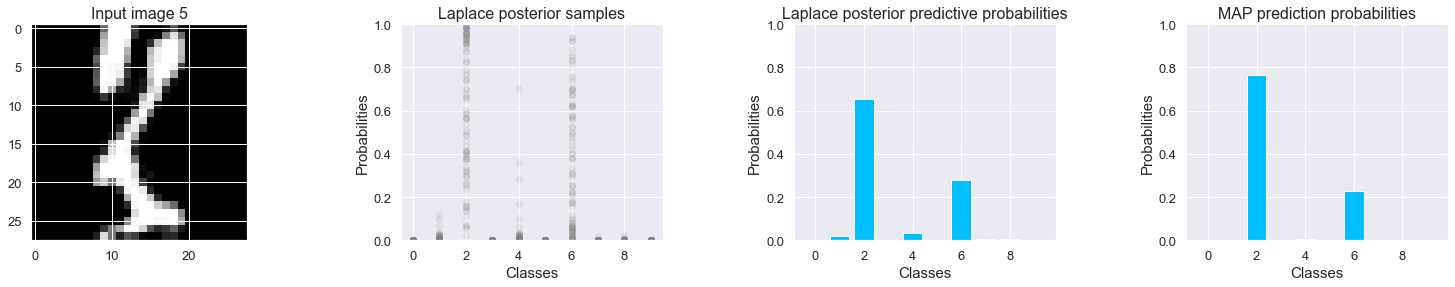

In [38]:
visualization.visualise_samples(last_ood_images,loader,test_ood,labels_ood,last_preds_ood,last_la_images_ood,map_images_ood)